In [12]:
import os,time,uuid,cv2

Collect Images Using OpenCV

In [13]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

Capture using camera

In [3]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print("Collecting image {}".format(imgnum))
    ret,frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname,frame)
    cv2.imshow('frame',frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [10]:
!labelme

[INFO   ] __init__:get_config:71 - Loading config file from: C:\Users\ASUS\.labelmerc
2023-09-12T09:21:52.060ZE [15300:ShellIpcClient] shell_ipc_client.cc:138:Connect Can't connect to socket at: \\.\Pipe\GoogleDriveFSPipe_ASUS_shell
2023-09-12T09:21:52.064ZE [15300:ShellIpcClient] shell_ipc_client.cc:621:operator() Failed to connect to the server: NOT_FOUND: Can't connect to socket at: \\.\Pipe\GoogleDriveFSPipe_ASUS_shell [type.googleapis.com/drive.ds.Status='UNAVAILABLE_RESOURCE']
=== Source Location Trace: ===
apps/drive/fs/ipc/shell_ipc_client.cc:139

2023-09-12T09:21:52.066ZE [14028:ShellIpcClient] shell_ipc_client.cc:138:Connect Can't connect to socket at: \\.\Pipe\GoogleDriveFSPipe_ASUS_shell
2023-09-12T09:21:52.066ZE [14028:ShellIpcClient] shell_ipc_client.cc:621:operator() Failed to connect to the server: NOT_FOUND: Can't connect to socket at: \\.\Pipe\GoogleDriveFSPipe_ASUS_shell [type.googleapis.com/drive.ds.Status='UNAVAILABLE_RESOURCE']
=== Source Location Trace: ===
apps/

### Review Dataset and Build Image Loading Function

Import packages

In [14]:
import tensorflow as tf
import cv2
import json 
import numpy as np
import matplotlib.pyplot as plt

Load Images into TF Data Pipeline

In [15]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [16]:
# images.as_numpy_iterator().next()

In [17]:
def load_images(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [18]:
images = images.map(load_images)

NameError: name 'images' is not defined

In [19]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [20]:
type(images)

NameError: name 'images' is not defined

View Raw Images with Matplotlib

In [21]:
image_generator = images.batch(4).as_numpy_iterator()

NameError: name 'images' is not defined

In [22]:
plot_images = image_generator.next()

NameError: name 'image_generator' is not defined

NameError: name 'plot_images' is not defined

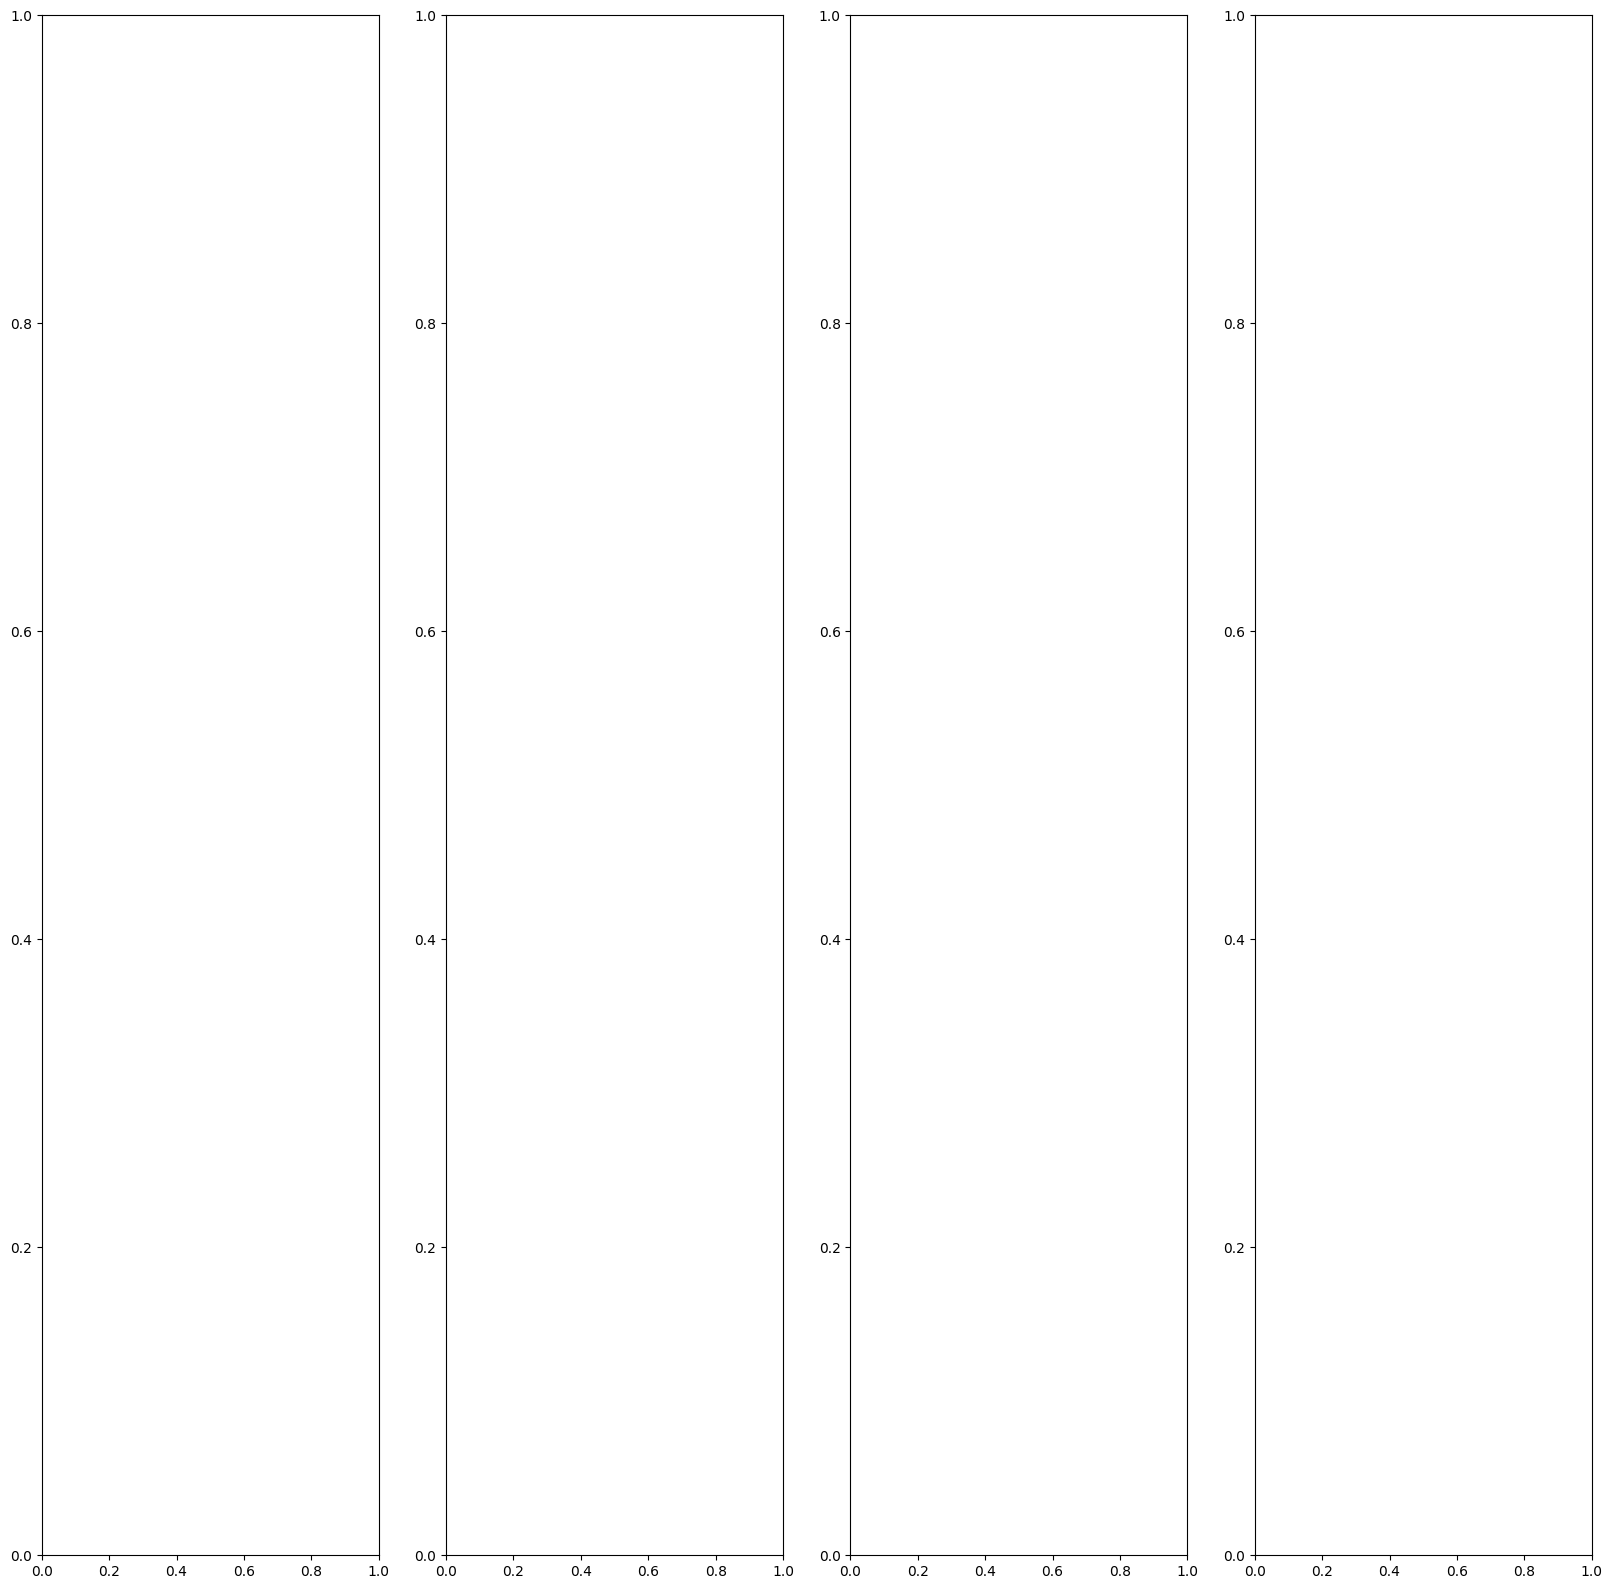

In [23]:
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx,image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

### Partition Unaugmented Data

In [24]:
train = len(images)*0.7
val = len(images)*0.15
test = len(images)*0.15
print(train,val,test)

NameError: name 'images' is not defined

In [25]:
train+test+val

NameError: name 'train' is not defined

In [26]:
train_size = 63
val_size = 14
test_size = 13

Move the matching labels

In [27]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

### Apply Image Augmentation

In [28]:
import albumentations as alb

Setup Albumentations Transform Pipeline

In [29]:
augmentor = alb.Compose([alb.RandomCrop(width=450,height=450),
            alb.HorizontalFlip(p=0.5),
            alb.RandomBrightnessContrast(p=0.2),
            alb.RandomGamma(p=0.2),
            alb.RGBShift(p=0.2),
            alb.VerticalFlip(p=0.5)],
            bbox_params=alb.BboxParams(format='albumentations',
            label_fields=['class_labels']))

Test on a image

In [30]:
img = cv2.imread(os.path.join('data','train','images','2a7c2370-514b-11ee-898f-e15febfc400a.jpg'))

In [31]:
with open(os.path.join('data','train','labels','2a7c2370-514b-11ee-898f-e15febfc400a.json'),'r') as f:
    label=json.load(f)


In [32]:
label['shapes'][0]['points']

[[31.827956989247326, 141.3440860215054],
 [322.15053763440864, 420.9139784946236]]

Extract Coordinates and Rescale to Match Image Resolution

In [33]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [34]:
coords

[31.827956989247326, 141.3440860215054, 322.15053763440864, 420.9139784946236]

In [35]:
coords = list(np.divide(coords,[640,480,640,480]))

In [36]:
coords

[0.04973118279569895,
 0.29446684587813626,
 0.5033602150537635,
 0.8769041218637992]

Apply Augmentations and View Results

In [37]:
augmented = augmentor(image=img,bboxes=[coords], class_labels=['face'])

In [38]:
augmented['bboxes']

[(0.5929988052568698, 0.3052090800477898, 1.0, 0.9264755077658303)]

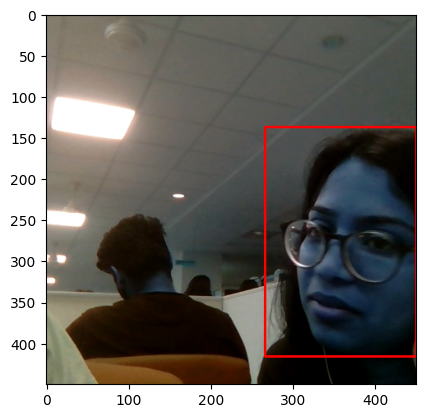

In [39]:
cv2.rectangle(augmented['image'],
    tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
    tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
    (255,0,0),2)

plt.imshow(augmented['image'])

### Build and Run Augmentation Pipeline

In [40]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Load Augmented Images to TF Dataset

In [41]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_images)
train_images = train_images.map(lambda x: tf.image.resize(x,(120,120)))
train_images = train_images.map(lambda x: x/255)

In [42]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_images)
test_images = test_images.map(lambda x: tf.image.resize(x,(120,120)))
test_images = test_images.map(lambda x: x/255)

In [43]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_images)
val_images = val_images.map(lambda x: tf.image.resize(x,(120,120)))
val_images = val_images.map(lambda x: x/255)

### Prepare Labels

In [44]:
import tensorflow as tf

In [45]:
def load_labels(label_path):
    with open(label_path.numpy(),'r',encoding='utf-8') as f:
        label = json.load(f)
    
    return [label['class']] , label['bbox']

In [46]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json',shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8,tf.float16]))

In [47]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json',shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8,tf.float16]))

In [48]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json',shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8,tf.float16]))

### Combine Label and Image Samples

In [49]:
len(train_images), len(train_labels),len(test_images),len(test_labels),len(val_images),len(val_labels)

(3780, 3780, 780, 780, 840, 840)

In [50]:
train = tf.data.Dataset.zip((train_images,train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [51]:
test = tf.data.Dataset.zip((test_images,test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [52]:
val = tf.data.Dataset.zip((val_images,val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [53]:
train.as_numpy_iterator().next()

(array([[[[3.67647074e-02, 1.23039216e-01, 1.15196079e-01],
          [4.26470600e-02, 1.28921568e-01, 1.21078432e-01],
          [3.54779400e-02, 1.21752448e-01, 1.13909312e-01],
          ...,
          [3.10784310e-01, 5.22549033e-01, 6.99999988e-01],
          [3.09313715e-01, 5.21078408e-01, 7.01470613e-01],
          [3.06311280e-01, 5.18076003e-01, 6.98468149e-01]],
 
         [[3.93995084e-02, 1.21752448e-01, 1.25674024e-01],
          [3.90318632e-02, 1.24571078e-01, 1.19424023e-01],
          [2.73897052e-02, 1.21507354e-01, 1.21507354e-01],
          ...,
          [3.30330878e-01, 5.38174033e-01, 7.10723042e-01],
          [3.26409310e-01, 5.30330896e-01, 7.14644611e-01],
          [3.04656863e-01, 5.08946061e-01, 6.93075955e-01]],
 
         [[3.77450995e-02, 1.20098040e-01, 1.24019608e-01],
          [2.69607846e-02, 1.10784315e-01, 1.14215687e-01],
          [1.91176478e-02, 1.13235295e-01, 1.13235295e-01],
          ...,
          [3.34191173e-01, 5.45955896e-01, 7.2634

In [54]:
data_samples = train.as_numpy_iterator()


In [55]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


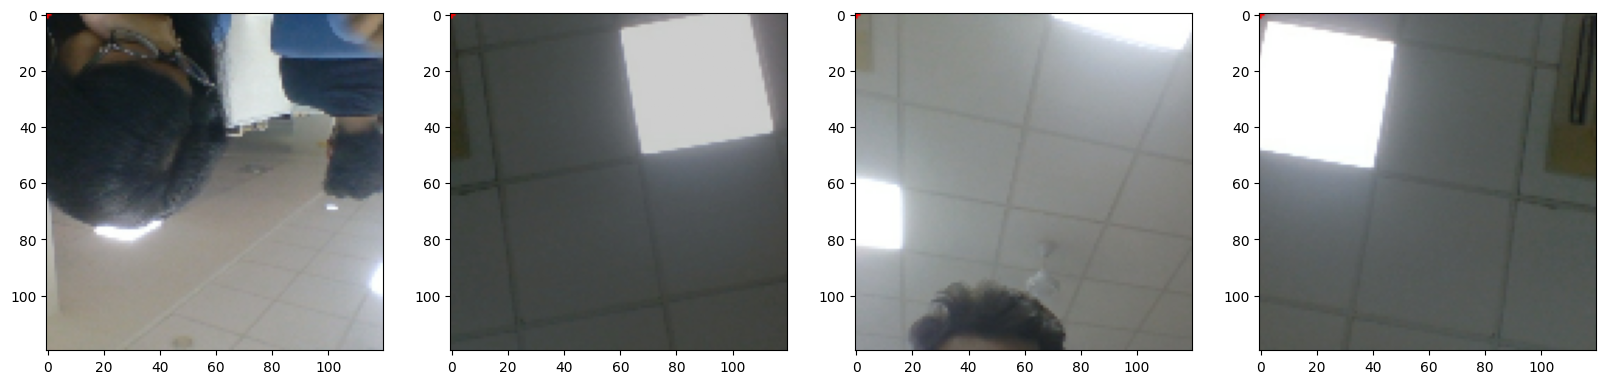

In [56]:
fig ,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                 tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),
                 tuple(np.multiply(sample_coords[2:],[120,120]).astype(int)),
                 (255,0,0), 2)
    ax[idx].imshow(sample_image)

### Build Deep Learning using Functional API

In [57]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Conv2D, Dense,GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [58]:
vgg = VGG16(include_top=False)

In [59]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [60]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [61]:
facetracker = build_model()

In [62]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [63]:
X,y = train.as_numpy_iterator().next()

In [64]:
X.shape

(8, 120, 120, 3)

In [65]:
classes,coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [66]:
classes ,coords

(array([[0.34306362],
        [0.42166385],
        [0.46079272],
        [0.5413246 ],
        [0.5276386 ],
        [0.44884676],
        [0.52162975],
        [0.44387242]], dtype=float32),
 array([[0.29589996, 0.43633708, 0.5120249 , 0.39696172],
        [0.43629587, 0.41105872, 0.5415308 , 0.48229307],
        [0.39930433, 0.48015082, 0.58266044, 0.44828337],
        [0.38099095, 0.54857194, 0.49315822, 0.4589611 ],
        [0.32536885, 0.5377518 , 0.5046162 , 0.47664228],
        [0.42100164, 0.4925322 , 0.5312902 , 0.39679357],
        [0.2846758 , 0.45917413, 0.5330385 , 0.51894116],
        [0.32107607, 0.4227259 , 0.5104168 , 0.47541767]], dtype=float32))

### Define Losses and Optimizers

In [67]:
batches_per_epoch = len(train)
lr_decay = (1.0/0.75 -1)/batches_per_epoch

In [68]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001,decay_steps=10000,decay_rate=lr_decay)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [69]:
def localization_loss(y_true,yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2]- yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1] # height
    w_true = y_true[:,2] - y_true[:,0] # width

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [70]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [71]:
localization_loss(y[1],coords).numpy()

3.8913097

In [72]:
classloss(y[1],classes).numpy()

0.6157857

In [73]:
regressloss(y[1],coords).numpy()

3.8913097

### Train Neural Network

In [74]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [75]:
model = FaceTracker(facetracker)

In [76]:
model.compile(opt,classloss,regressloss)

In [77]:
logdir = 'logs'

In [78]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [79]:
hist = model.fit(train, epochs=3, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/3


473/473 [==============================] - 775s 2s/step - total_loss: 0.5629 - class_loss: 0.2243 - regress_loss: 0.4508 - val_total_loss: 0.2214 - val_class_loss: 0.0201 - val_regress_loss: 0.2114
Epoch 2/3
473/473 [==============================] - 766s 2s/step - total_loss: 0.1295 - class_loss: 0.0580 - regress_loss: 0.1005 - val_total_loss: 0.0140 - val_class_loss: 0.0095 - val_regress_loss: 0.0093
Epoch 3/3
473/473 [==============================] - 730s 2s/step - total_loss: 0.0766 - class_loss: 0.0335 - regress_loss: 0.0599 - val_total_loss: 0.0080 - val_class_loss: 7.9404e-04 - val_regress_loss: 0.0076


In [80]:
hist.history

{'total_loss': [0.28855466842651367,
  0.0056040422059595585,
  0.06372755765914917],
 'class_loss': [0.2587224841117859, 0.00722899055108428, 0.056962545961141586],
 'regress_loss': [0.15919342637062073,
  0.0019895469304174185,
  0.03524628281593323],
 'val_total_loss': [0.221420019865036,
  0.013998543843626976,
  0.007956011220812798],
 'val_class_loss': [0.02007436566054821,
  0.009494488127529621,
  0.0007940438226796687],
 'val_regress_loss': [0.21138283610343933,
  0.009251300245523453,
  0.007558989338576794]}

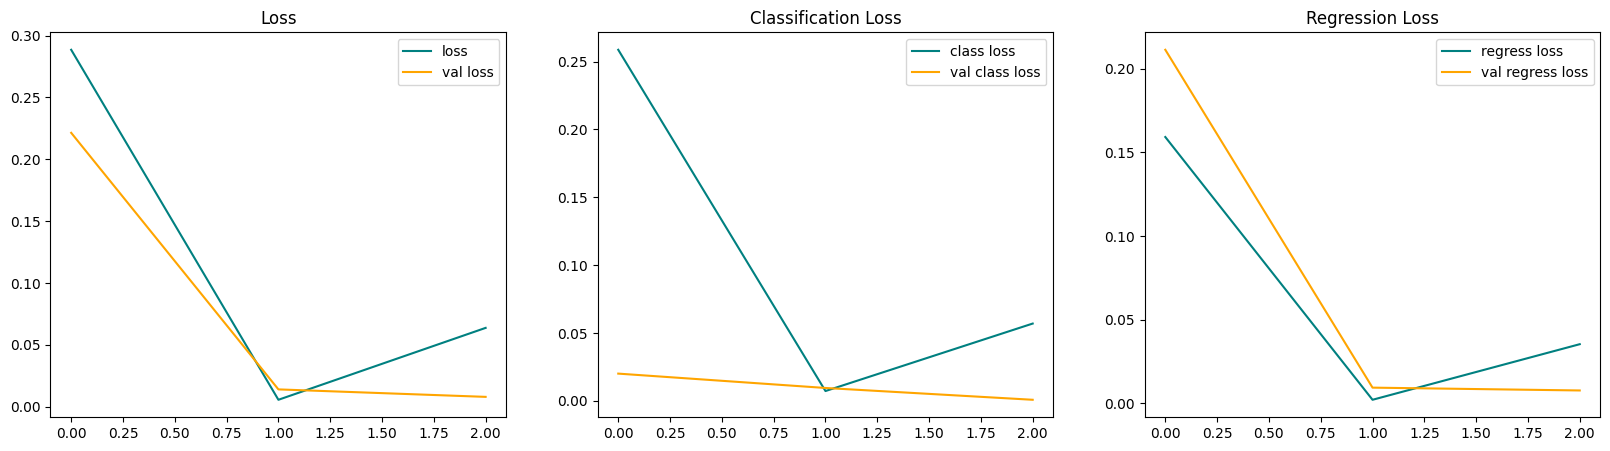

In [81]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [82]:
test_data = test.as_numpy_iterator()

In [83]:
test_sample = test_data.next()

In [84]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 312ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


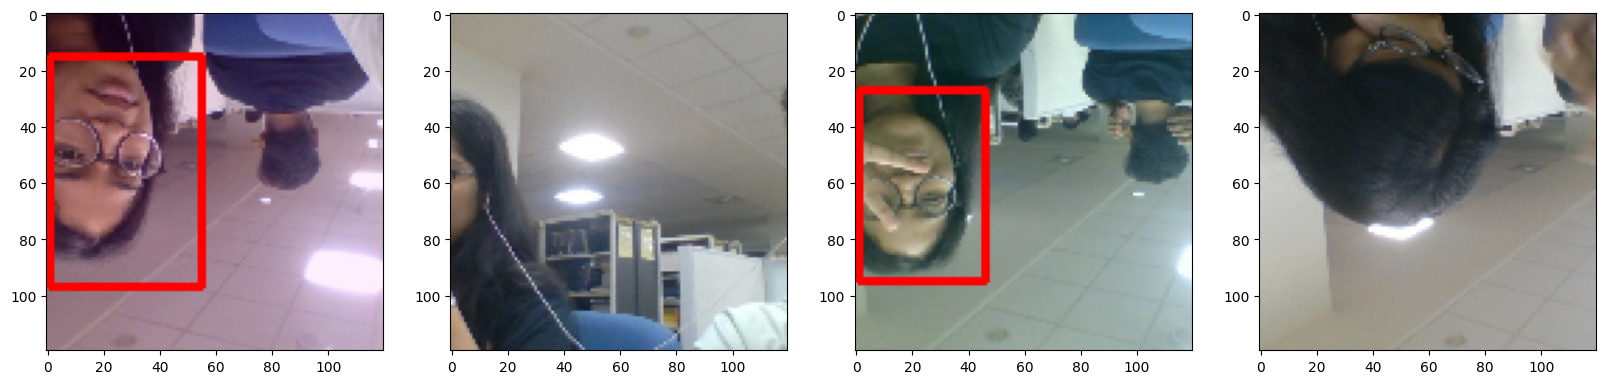

In [85]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

Save the Model

In [86]:
from tensorflow.keras.models import load_model

In [87]:
facetracker.save('facetracker.h5')

In [88]:
facetracker = load_model('facetracker.h5')

### Real Time Detection

In [89]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 77ms/step
